In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



# Download NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...


True

In [7]:
data = pd.read_csv("C:\\Users\\Vinay\\Downloads\\Training_Essay_Data.csv")

In [8]:
data.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


<BarContainer object of 2 artists>

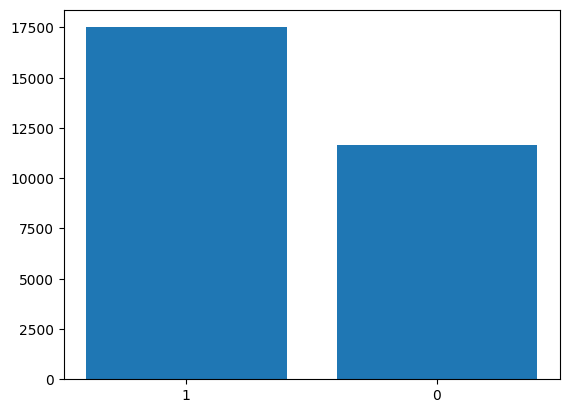

In [9]:
plt.bar(x = ['1', '0'], height = data['generated'].value_counts())

In [10]:
data.columns

Index(['text', 'generated'], dtype='object')

In [11]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text



In [12]:
# Preprocess text data
data['processed_text'] = data['text'].apply(preprocess_text)

In [13]:
data.head()

,text,generated,processed_text
0,Car-free cities have become a subject of incre...,1,carfree city become subject increasing interes...
1,"Car Free Cities Car-free cities, a concept ga...",1,car free city carfree city concept gaining tra...
2,A Sustainable Urban Future Car-free cities ...,1,sustainable urban future carfree city emerging...
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living era marked...
4,The Path to Sustainable Urban Living In an ...,1,path sustainable urban living age rapid urbani...


In [14]:
X = data['processed_text']
y = data['generated']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Convert sparse matrices to numpy arrays
X_train_vectors = X_train_vectors.toarray()
X_test_vectors = X_test_vectors.toarray()

# Calculate cosine similarity with reference vector
human_reference_vector = np.mean(X_train_vectors[y_train == 0], axis=0)  # Reference vector for human-written essays
cosine_similarity_train = cosine_similarity(X_train_vectors, [human_reference_vector])
cosine_similarity_test = cosine_similarity(X_test_vectors, [human_reference_vector])

# Train logistic regression model using cosine similarity scores
model = LogisticRegression()
model.fit(cosine_similarity_train, y_train)

# Predict labels for the testing set
y_pred = model.predict(cosine_similarity_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8498884885915251


In [16]:
#export vectorizor and lr model
import pickle

# Save vectorizer
with open('lr_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save logistic regression model
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [17]:
del model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare features (X) and labels (y)
X = data['processed_text']
y = data['generated']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Convert sparse matrices to numpy arrays
X_train_vectors = X_train_vectors.toarray()
X_test_vectors = X_test_vectors.toarray()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define neural network architecture
model = Sequential([
    Dense(64, input_dim=X_train_vectors.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train_vectors, y_train, epochs=100, batch_size=32, validation_data=(X_test_vectors, y_test), callbacks=[early_stopping])

# Evaluate model performance
loss, accuracy = model.evaluate(X_test_vectors, y_test)
print("Accuracy:", accuracy)

c:\Users\Vinay\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
729/729 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9593 - loss: 0.1742 - val_accuracy: 0.9962 - val_loss: 0.0128
Epoch 2/100
729/729 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9966 - val_loss: 0.0124
Epoch 3/100
729/729 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 1.0000 - loss: 2.8831e-04 - val_accuracy: 0.9973 - val_loss: 0.0125
Epoch 4/100
729/729 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 1.0000 - loss: 7.6573e-05 - val_accuracy: 0.9973 - val_loss: 0.0137
Epoch 5/100
729/729 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 1.0000 - loss: 2.4603e-05 - val_accuracy: 0.9973 - val_loss: 0.0147
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.0088
Accuracy: 0.9965688586235046


In [21]:
from tensorflow.keras.models import save_model

# Save the model
save_model(model, 'nn_model.keras')

In [22]:
from sklearn.metrics import confusion_matrix

# Predict probabilities for each class
y_pred_probabilities = model.predict(X_test_vectors)

# Convert probabilities to binary predictions
y_pred = (y_pred_probabilities > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[3534    5]
 [  15 2275]]
